In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from dataset import Dataset

import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import manifold, datasets

%load_ext autoreload
%autoreload 2

In [2]:
from diffusion_map import DiffusionMap
from datafold.utils.plot import plot_pairwise_eigenvector

In [3]:
def plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, time):
    """
    Plot different graphs with respect to selected part.
    """
    # print(f"{n_evecs} Largest eigenvalues with respect this dataset: \n {evals}")
    idx_plot = np.random.permutation(nr_samples)[0:nr_samples_plot]

    if part == 1 or part == 2:
        plot_pairwise_eigenvector(
            eigenvectors=evecs[idx_plot, :],
            n=1,
            fig_params=dict(figsize=[15, 15]),
            scatter_params=dict(cmap=plt.cm.Spectral, c=time[idx_plot],s=0.5)
        ) 
    elif part == 3:
        pass
    
    plt.show()


## Initializations:

In [4]:
nr_samples = 20000         # Number of samples
nr_samples_plot = 20000    # Number of samples to plot
n_evecs = 10              # L+1 largest eigenfunctions
radius = 1                # Radius around a point for distance computation

### Make Swiss-roll Data Set

In [5]:
part = 1

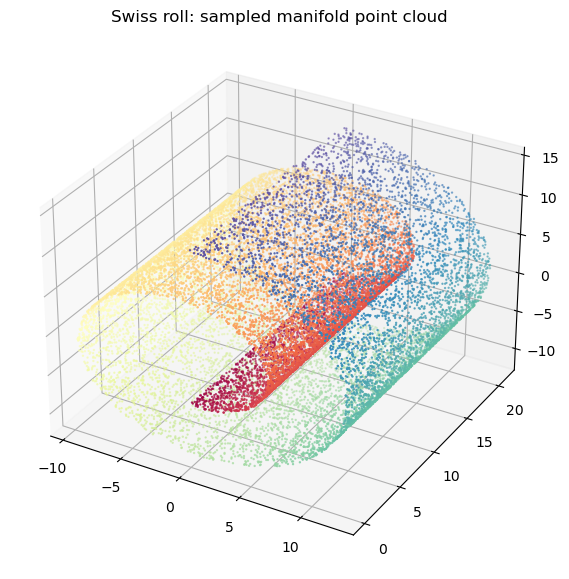

In [6]:
dataset = Dataset(nr_samples, nr_samples_plot)
positions, positions_color = dataset.generate_swiss_roll()
dataset.plot_swiss_roll(positions, positions_color)

### Part 1: Swiss-roll Data set embedding using our Diffusion Map

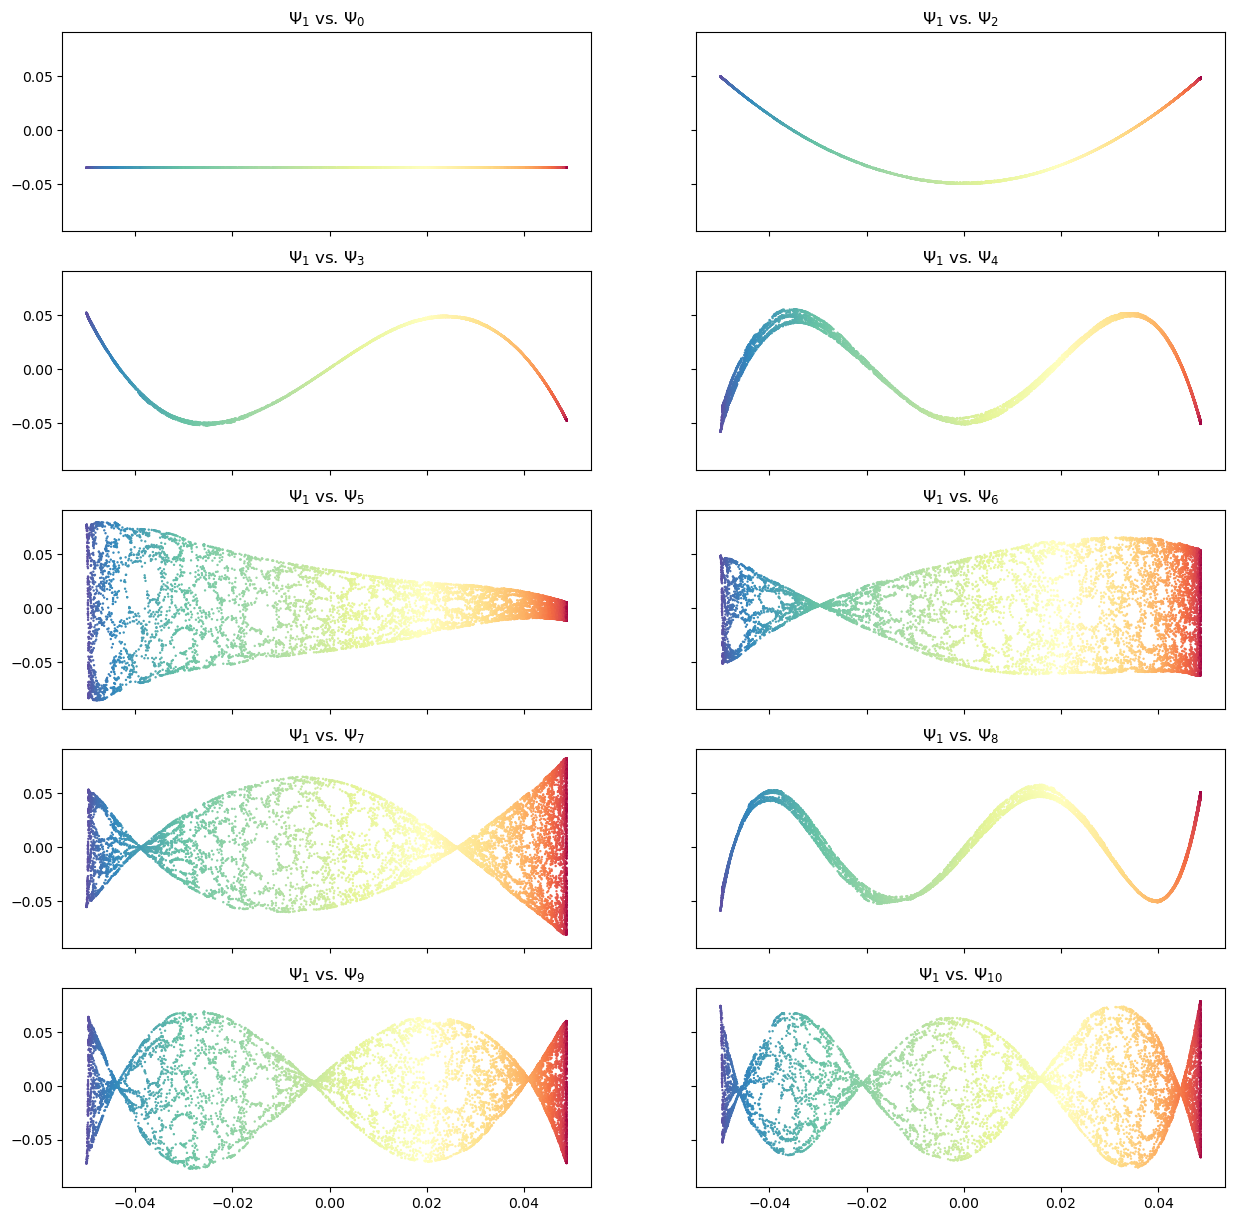

In [25]:
dmap = DiffusionMap()
evecs, evals = dmap.compute_eigenfunctions(positions, n_evecs, radius)

# Plot the eigenfunction phi_1 with respect to the others
plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, positions_color)

## Part 2: Swiss-roll Data set embedding using DataFold Library

In [16]:
part = 2

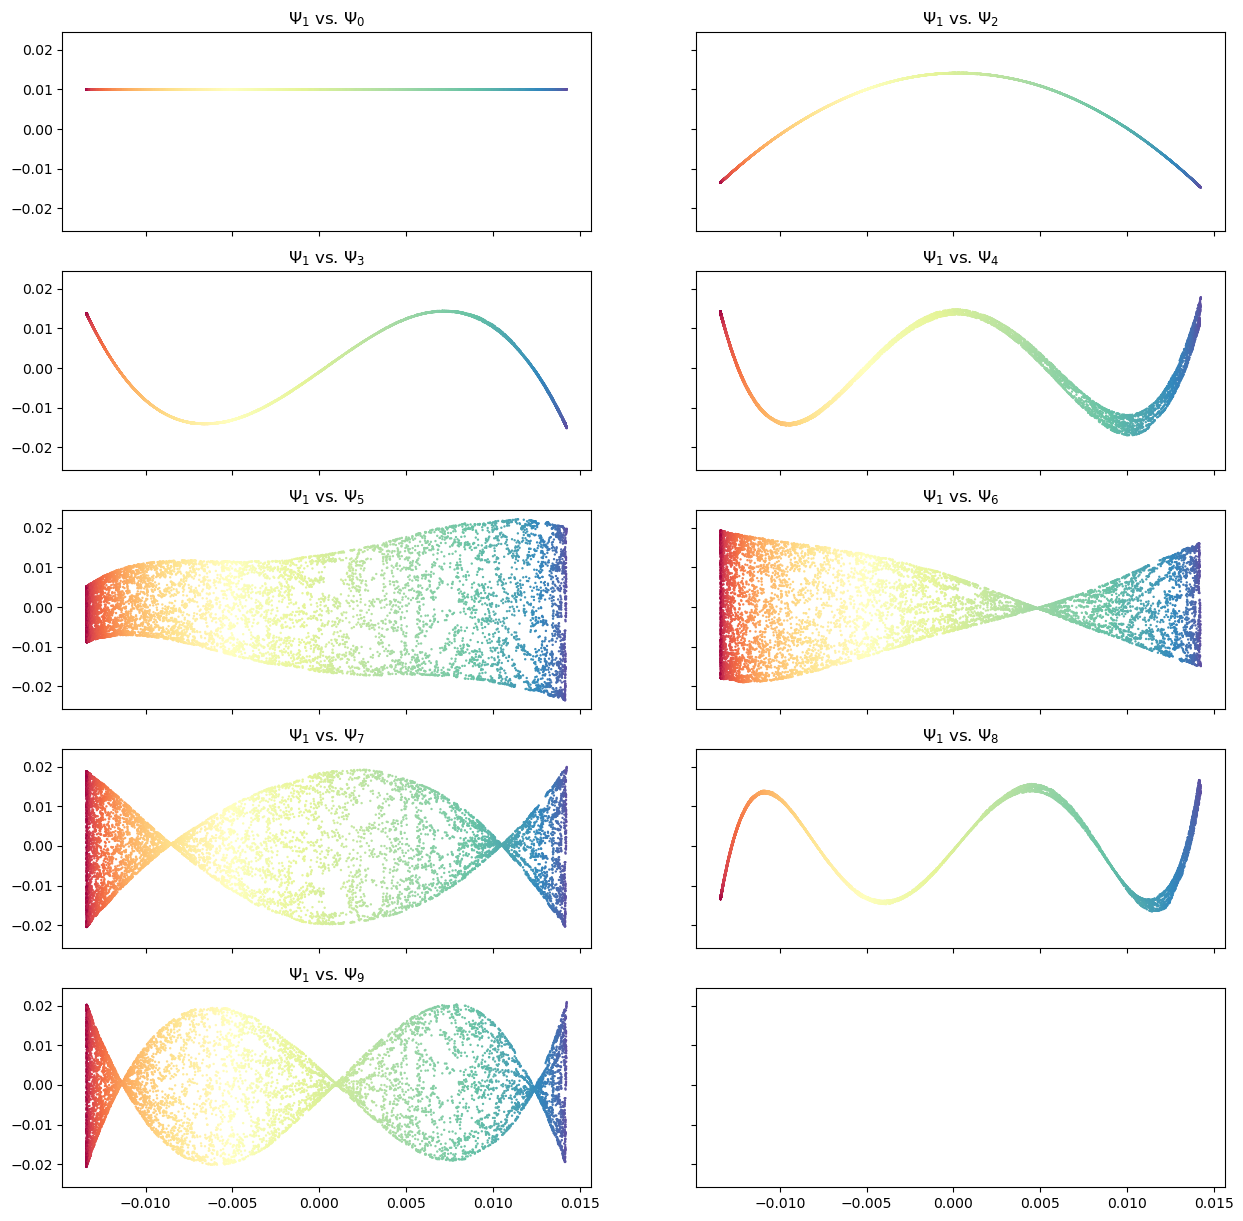

In [17]:
dmap = DiffusionMap()
evecs, evals = dmap.compute_eigenfunctions_datafold(positions, n_evecs)

# Plot the eigenfunction phi_1 with respect to the others
plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, positions_color)

### Part 3: Swiss-roll Data set embedding using Sklearn Isomap Library

In [7]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    # ax.scatter(x, y, cmap=plt.cm.Spectral, c=points_color, s=0.5, alpha=0.8)
    ax.scatter(x, y, c=points_color, s=0.5, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [8]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 4), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

In [9]:
n_neighbors = 20  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [10]:
isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
S_isomap = isomap.fit_transform(positions)

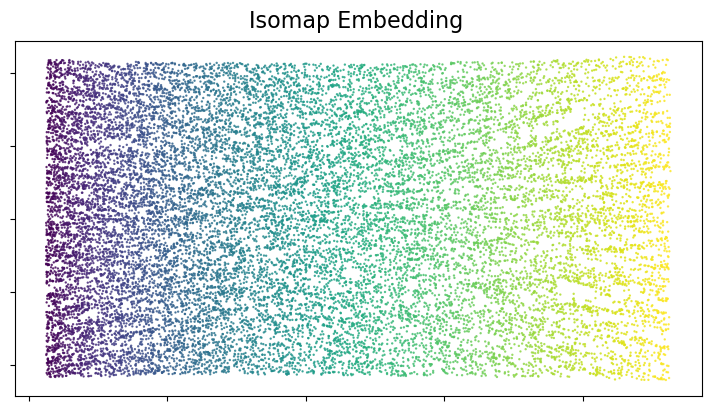

In [11]:
plot_2d(S_isomap, positions_color, "Isomap Embedding")

In [18]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

In [19]:
with open('isomap_label.npy', 'wb') as f:
    np.save(f, S_isomap)

In [24]:
with open('isomap_input.npy', 'wb') as f:
    np.save(f, positions)

In [22]:
with open('isomap_label.npy', 'rb') as f:
    a = np.load(f)
print(a)

[[-8.50395774e+00 -2.17115573e+00]
 [ 1.52790232e+01  6.51123821e+00]
 [ 2.22858702e-02  3.24625852e+00]
 ...
 [-3.70660376e+01 -5.17328586e+00]
 [-1.69900753e+01  1.50595442e+00]
 [-3.56720461e+00  7.90969094e+00]]


### Part 4: Swiss-roll Data set embedding using Megaman Isomap Library

In [4]:
from megaman.geometry import Geometry
from megaman.embedding import Isomap
import time

In [5]:
n_components = 2
radius = 0.5

In [6]:
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kmeans', 'branching':64, 'iterations':20, 'cb_index':0.4}
# adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
adjacency_kwds = {'n_neighbors': 20}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

In [7]:
geom.set_data_matrix(positions)

NameError: name 'positions' is not defined

In [107]:
from scipy.sparse.csgraph import connected_components

radius = 1.0
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':radius}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':radius}
affinity_matrix = geom.compute_affinity_matrix({'radius':radius})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

1


In [108]:
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(positions)

/home/erfan/anaconda3/envs/manifold_env/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [10]:
fig, ax = plt.subplots(figsize=(7, 4), facecolor="white", constrained_layout=True)
ax.set_title('Isomap using megaman')
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=0.5, c=positions_color)
plt.show()

### Part 5: World2vec Data set embedding using Sklearn Isomap Library

In [25]:
import gensim.downloader

In [26]:
google_news_vecs = gensim.downloader.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:
vecs = google_news_vecs.vectors
vecs.shape

NameError: name 'wv' is not defined